# Kolkata Traffic — EDA & Traffic Level Classification

In [1]:
# 1) Imports and load dataset
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import warnings, joblib
warnings.filterwarnings('ignore')
sns.set_theme()

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

# Load the uploaded dataset
df = pd.read_csv("Dataset_Uber Traffic.csv", parse_dates=['DateTime'])
print('Loaded dataset with shape:', df.shape)
df.head()


Loaded dataset with shape: (48120, 4)


,DateTime,Junction,Vehicles,ID
0,2015-01-11 00:00:00,1,15,20151101001
1,2015-01-11 01:00:00,1,13,20151101011
2,2015-01-11 02:00:00,1,10,20151101021
3,2015-01-11 03:00:00,1,7,20151101031
4,2015-01-11 04:00:00,1,9,20151101041


## 2) Quick data checks

In [2]:
# Quick checks: columns, dtypes, missing values
print('Columns:', df.columns.tolist())
print('\nDtypes:\n', df.dtypes)
print('\nMissing values:\n', df.isnull().sum())
print('\nDuplicate rows:', df.duplicated().sum())

# Show basic statistics
df.describe(include='all').T


Columns: ['DateTime', 'Junction', 'Vehicles', 'ID']

Dtypes:
 DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

Missing values:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Duplicate rows: 0


,count,mean,min,25%,50%,75%,max,std
DateTime,48120,2016-09-26 15:27:43.541147136,2015-01-11 00:00:00,2016-04-16 01:45:00,2016-09-30 03:30:00,2017-03-15 16:00:00,2017-12-06 23:00:00,NaN
Junction,48120.0,2.180549,1.0,1.0,2.0,3.0,4.0,0.966955
Vehicles,48120.0,22.791334,1.0,9.0,15.0,29.0,180.0,20.750063
ID,48120.0,20163302501.220448,20151101001.0,20160416019.0,20160930037.0,20170225162.25,20170630234.0,5944853.800152


## 3) Data cleaning & aggregation
- Handle missing values (drop or impute)
- Remove duplicates
- Aggregate to hourly per junction if necessary

(Adjust code below if your raw data already is hourly.)

In [3]:
# Example cleaning steps (customize if needed)
# Drop duplicates
df = df.drop_duplicates()

# If DateTime not rounded to hour, round down to hour (floor)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['DateHour'] = df['DateTime'].dt.floor('H')

# If dataset has multiple rows per junction per hour, aggregate by sum or mean of Traffic_Volume
if df.duplicated(subset=['DateHour','Junction']).any():
    df = df.groupby(['DateHour','Junction']).agg({
        'Traffic_Volume':'sum',    # vehicle counts sum
        'Temperature':'mean',
        'Humidity':'mean',
        'Rainfall_mm':'sum',
        'Holiday_Event':'max'      # if any row is holiday event
    }).reset_index().rename(columns={'DateHour':'DateTime'})

# Quick check after cleaning
print('After cleaning shape:', df.shape)
df.head()


After cleaning shape: (48120, 5)


,DateTime,Junction,Vehicles,ID,DateHour
0,2015-01-11 00:00:00,1,15,20151101001,2015-01-11 00:00:00
1,2015-01-11 01:00:00,1,13,20151101011,2015-01-11 01:00:00
2,2015-01-11 02:00:00,1,10,20151101021,2015-01-11 02:00:00
3,2015-01-11 03:00:00,1,7,20151101031,2015-01-11 03:00:00
4,2015-01-11 04:00:00,1,9,20151101041,2015-01-11 04:00:00


## 4) Feature engineering
- Create Hour, DayOfWeek, Month
- Create `traffic_level` using data-driven quantiles (Low/Medium/High)

In [4]:
print(df.columns)

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'DateHour'], dtype='object')


In [5]:
# Time features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Is_Weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Create traffic_level by quantiles (33%, 66%)
q_low = df['Vehicles'].quantile(0.33)
q_high = df['Vehicles'].quantile(0.66)
print(f'Quantiles for Vehicles -> low: {q_low:.1f}, high: {q_high:.1f}')

def level_cat(x):
    if x <= q_low:
        return 'Low'
    elif x <= q_high:
        return 'Medium'
    else:
        return 'High'

df['traffic_level'] = df['Vehicles'].apply(level_cat)
df['traffic_level'] = df['traffic_level'].astype('category')
print(df['traffic_level'].value_counts(normalize=True).round(3))

Quantiles for Vehicles -> low: 11.0, high: 22.0
traffic_level
Low       0.368
High      0.332
Medium    0.300
Name: proportion, dtype: float64


## 5) EDA — Visualizations (run and note observations)

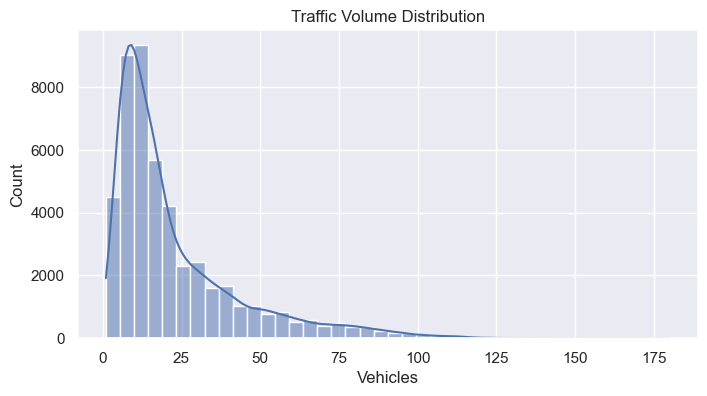

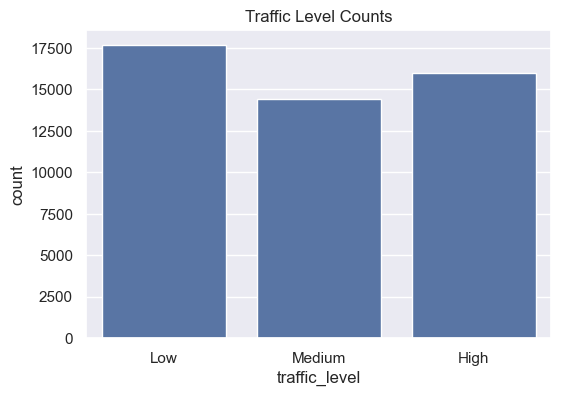

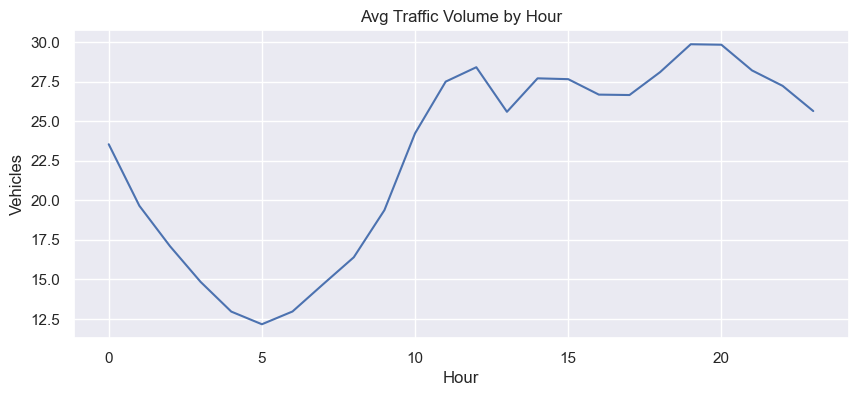

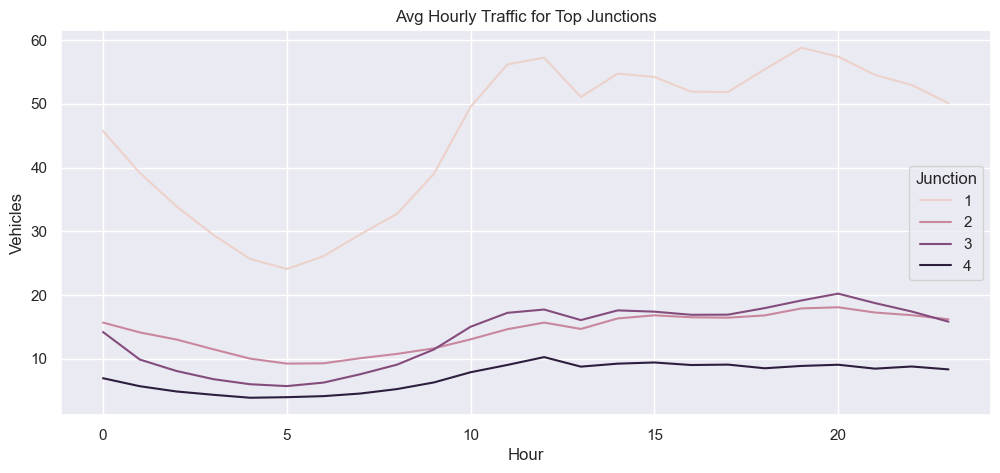

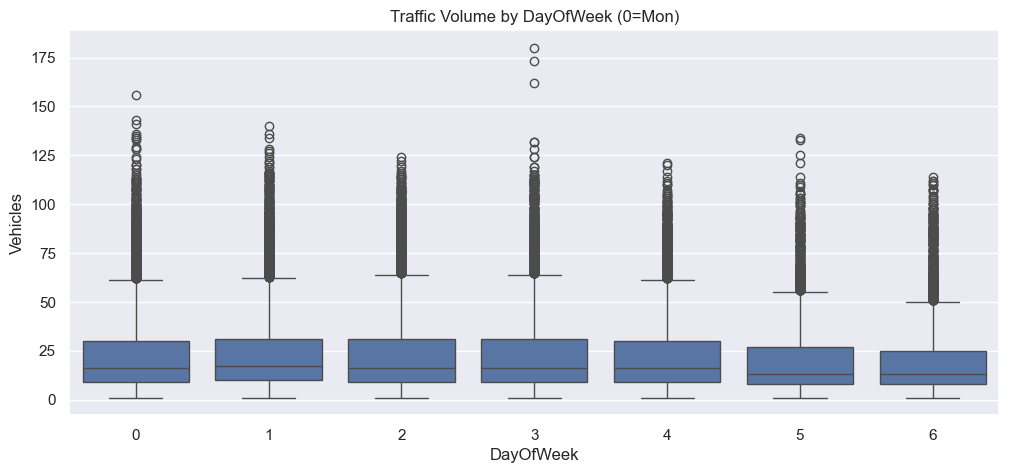

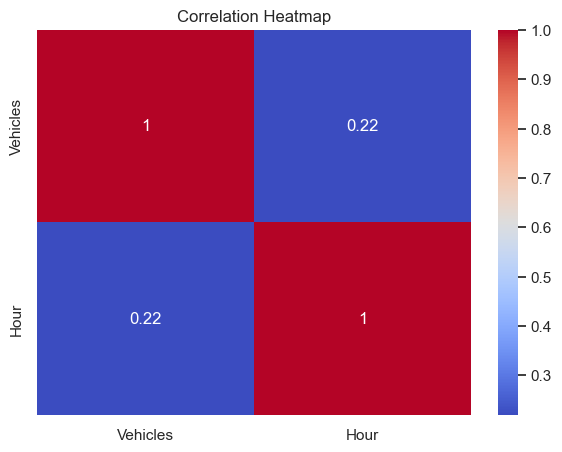

In [6]:
# Distribution of Traffic Volume
plt.figure(figsize=(8,4))
sns.histplot(df['Vehicles'], bins=40, kde=True)
plt.title('Traffic Volume Distribution')
plt.xlabel('Vehicles')
plt.show()

# Traffic level counts
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='traffic_level', order=['Low','Medium','High'])
plt.title('Traffic Level Counts')
plt.show()

# Average traffic by hour
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df.groupby('Hour')['Vehicles'].mean().reset_index(),
    x='Hour', y='Vehicles'
)
plt.title('Avg Traffic Volume by Hour')
plt.show()

# Traffic by junction (sample major junctions if many)
top_junctions = df['Junction'].value_counts().nlargest(6).index.tolist()
plt.figure(figsize=(12,5))
sns.lineplot(
    data=df[df['Junction'].isin(top_junctions)]
           .groupby(['Hour','Junction'])['Vehicles']
           .mean()
           .reset_index(),
    x='Hour', y='Vehicles', hue='Junction'
)
plt.title('Avg Hourly Traffic for Top Junctions')
plt.show()

# Boxplot by weekday
plt.figure(figsize=(12,5))
sns.boxplot(x='DayOfWeek', y='Vehicles', data=df)
plt.title('Traffic Volume by DayOfWeek (0=Mon)')
plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(7,5))
numeric_cols = ['Vehicles', 'Hour']
# Include these only if they exist in your dataset
for col in ['Temperature','Humidity','Rainfall_mm']:
    if col in df.columns:
        numeric_cols.append(col)

sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## 6) Prepare dataset for classification
- One-hot encode junctions and scale numeric features
- Time-based train/test split (chronological)

In [7]:
# Features to use
features = ['Hour','DayOfWeek','Month','Is_Weekend']  # Removed Temperature, Humidity, Rainfall_mm

# One-hot encode Junction
df_enc = pd.get_dummies(df[features + ['Junction']], columns=['Junction'], drop_first=True)

# Encode target
df_enc['traffic_level'] = df['traffic_level'].cat.codes  # 0..2

# Optional: preserve mapping
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['traffic_label'] = le.fit_transform(df['traffic_level'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label mapping:', mapping)

# Merge labels with encoded df
df_enc['traffic_label'] = df['traffic_label'].values
df_enc['DateTime'] = df['DateTime'].values

# Sort chronologically and split
df_enc = df_enc.sort_values('DateTime').reset_index(drop=True)
split_idx = int(0.8 * len(df_enc))
train = df_enc.iloc[:split_idx].copy()
test  = df_enc.iloc[split_idx:].copy()

X_train = train.drop(['traffic_label','DateTime'], axis=1)
y_train = train['traffic_label']
X_test  = test.drop(['traffic_label','DateTime'], axis=1)
y_test  = test['traffic_label']

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Label mapping: {'High': 0, 'Low': 1, 'Medium': 2}
Train shape: (38496, 8) Test shape: (9624, 8)


## 7) Scaling Numeric Features Using StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Scaling done for columns:", numeric_cols)


Scaling done for columns: ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend']


## 8) Train baseline classifiers (Logistic Regression, Random Forest, XGBoost if available)

In [9]:
# Logistic Regression (multinomial)
lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost (optional)
if xgb_available:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
else:
    y_pred_xgb = None

print('Models trained.')


Models trained.


## 9) Evaluation - accuracy, f1, classification report, confusion matrix

--- Logistic Regression ---
Accuracy: 1.0
F1 (macro): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4051
           1       1.00      1.00      1.00      3092
           2       1.00      1.00      1.00      2481

    accuracy                           1.00      9624
   macro avg       1.00      1.00      1.00      9624
weighted avg       1.00      1.00      1.00      9624



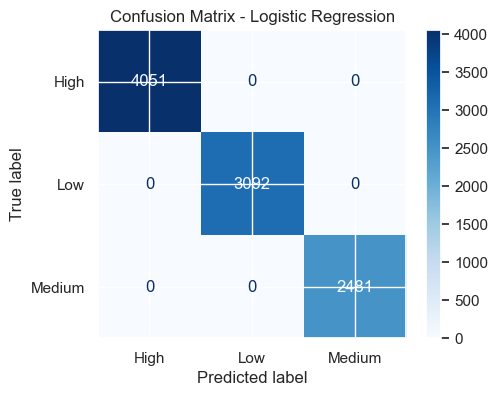

--- Random Forest ---
Accuracy: 1.0
F1 (macro): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4051
           1       1.00      1.00      1.00      3092
           2       1.00      1.00      1.00      2481

    accuracy                           1.00      9624
   macro avg       1.00      1.00      1.00      9624
weighted avg       1.00      1.00      1.00      9624



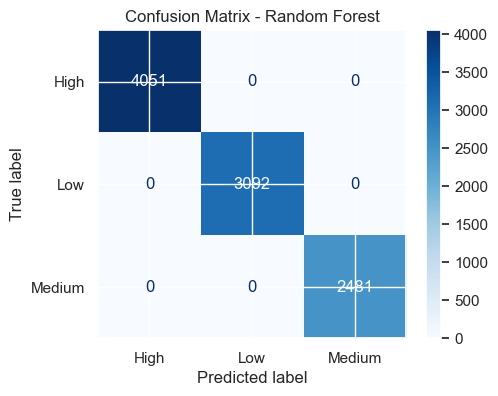

--- XGBoost ---
Accuracy: 1.0
F1 (macro): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4051
           1       1.00      1.00      1.00      3092
           2       1.00      1.00      1.00      2481

    accuracy                           1.00      9624
   macro avg       1.00      1.00      1.00      9624
weighted avg       1.00      1.00      1.00      9624



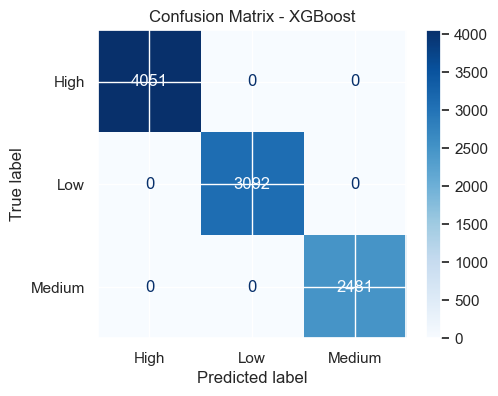

In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def eval_and_report(y_true, y_pred, model_name):
    print('---', model_name, '---')
    print('Accuracy:', round(accuracy_score(y_true, y_pred),4))
    print('F1 (macro):', round(f1_score(y_true, y_pred, average='macro'),4))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Evaluate models
eval_and_report(y_test, y_pred_lr, 'Logistic Regression')
eval_and_report(y_test, y_pred_rf, 'Random Forest')
if y_pred_xgb is not None:
    eval_and_report(y_test, y_pred_xgb, 'XGBoost')


## 10) Feature importance (Random Forest)

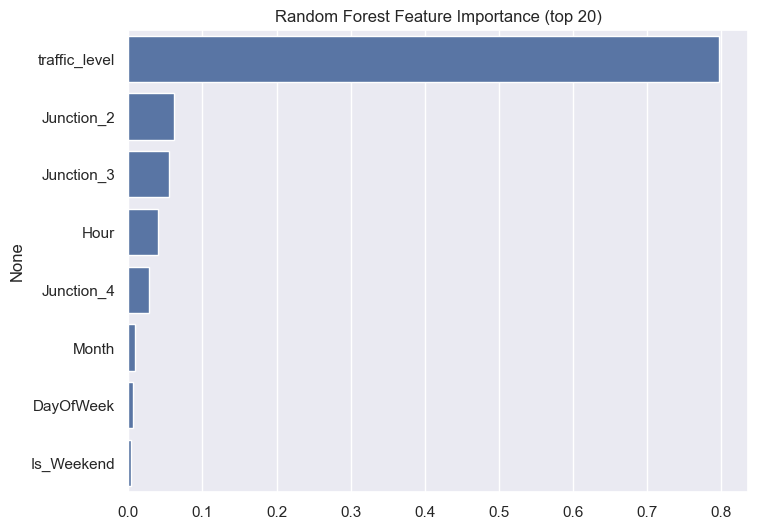

In [11]:
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title('Random Forest Feature Importance (top 20)')
plt.show()


## 11) Save outputs & artifacts

In [12]:
# Save CSV with levels and models
df.to_csv('integrated_kolkata_with_levels.csv', index=False)
joblib.dump(rf, 'rf_traffic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print('Saved: integrated_kolkata_with_levels.csv, rf_traffic_model.pkl, scaler.pkl, label_encoder.pkl')


Saved: integrated_kolkata_with_levels.csv, rf_traffic_model.pkl, scaler.pkl, label_encoder.pkl


## 12) Conclusion 

- **The numeric features (Hour, DayOfWeek, Month, Is_Weekend) have been standardized so that each has a mean of 0 and a standard deviation of 1 in both training and test sets. This ensures that all features contribute equally to the model and improves the performance and convergence of machine learning algorithms**.